# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.269951390800136 -2.6495541147104222
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [19]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    #Qs_labels = targetQs[1:]
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    #g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
    #                                                                  labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [20]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [21]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [22]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [23]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [24]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [25]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [34]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/modelR.ckpt')

Episode:0 meanR:9.0000 rate:0.0180 gloss:0.0477 dloss:0.7287 dlossR:0.7287 dlossQ:0.6923
Episode:1 meanR:8.5000 rate:0.0160 gloss:0.0148 dloss:0.6996 dlossR:0.6996 dlossQ:0.6931
Episode:2 meanR:9.0000 rate:0.0200 gloss:-0.0058 dloss:0.6765 dlossR:0.6765 dlossQ:0.6932
Episode:3 meanR:8.7500 rate:0.0160 gloss:-0.0249 dloss:0.6583 dlossR:0.6583 dlossQ:0.6929
Episode:4 meanR:8.8000 rate:0.0180 gloss:-0.0460 dloss:0.6315 dlossR:0.6315 dlossQ:0.6919
Episode:5 meanR:8.8333 rate:0.0180 gloss:-0.0677 dloss:0.6094 dlossR:0.6094 dlossQ:0.6905
Episode:6 meanR:8.8571 rate:0.0180 gloss:-0.0912 dloss:0.5888 dlossR:0.5888 dlossQ:0.6886
Episode:7 meanR:8.7500 rate:0.0160 gloss:-0.1168 dloss:0.5760 dlossR:0.5760 dlossQ:0.6874
Episode:8 meanR:9.0000 rate:0.0220 gloss:-0.1614 dloss:0.5326 dlossR:0.5326 dlossQ:0.6794
Episode:9 meanR:9.1000 rate:0.0200 gloss:0.2645 dloss:0.9009 dlossR:0.9009 dlossQ:0.6751
Episode:10 meanR:9.1818 rate:0.0200 gloss:0.2326 dloss:0.8793 dlossR:0.8793 dlossQ:0.6778
Episode:11 me

Episode:94 meanR:27.0632 rate:0.0320 gloss:-1.5091 dloss:0.1647 dlossR:0.1647 dlossQ:0.3639
Episode:95 meanR:26.9062 rate:0.0240 gloss:-1.5192 dloss:0.1434 dlossR:0.1434 dlossQ:0.3779
Episode:96 meanR:26.7526 rate:0.0240 gloss:-1.5823 dloss:0.1392 dlossR:0.1392 dlossQ:0.3652
Episode:97 meanR:26.6020 rate:0.0240 gloss:-1.5999 dloss:0.1383 dlossR:0.1383 dlossQ:0.3624
Episode:98 meanR:26.4646 rate:0.0260 gloss:-1.6636 dloss:0.1402 dlossR:0.1402 dlossQ:0.3566
Episode:99 meanR:26.3300 rate:0.0260 gloss:-1.6817 dloss:0.1392 dlossR:0.1392 dlossQ:0.3538
Episode:100 meanR:26.3400 rate:0.0200 gloss:-1.6752 dloss:0.1217 dlossR:0.1217 dlossQ:0.3662
Episode:101 meanR:26.3600 rate:0.0200 gloss:-1.7358 dloss:0.1183 dlossR:0.1183 dlossQ:0.3580
Episode:102 meanR:26.6500 rate:0.0780 gloss:-1.5678 dloss:0.2752 dlossR:0.2752 dlossQ:0.3329
Episode:103 meanR:28.2500 rate:0.3360 gloss:-1.3394 dloss:0.8756 dlossR:0.8756 dlossQ:0.3842
Episode:104 meanR:28.8000 rate:0.1280 gloss:-1.4279 dloss:0.3895 dlossR:0.38

Episode:184 meanR:36.7000 rate:0.1180 gloss:-1.5174 dloss:0.3761 dlossR:0.3761 dlossQ:0.3591
Episode:185 meanR:36.7100 rate:0.0740 gloss:-1.6863 dloss:0.2723 dlossR:0.2723 dlossQ:0.3274
Episode:186 meanR:36.7800 rate:0.0560 gloss:-1.7693 dloss:0.2256 dlossR:0.2256 dlossQ:0.3154
Episode:187 meanR:37.0500 rate:0.0980 gloss:-1.6104 dloss:0.3331 dlossR:0.3331 dlossQ:0.3511
Episode:188 meanR:37.2700 rate:0.0860 gloss:-1.6164 dloss:0.2950 dlossR:0.2950 dlossQ:0.3207
Episode:189 meanR:37.4900 rate:0.0820 gloss:-1.6334 dloss:0.2852 dlossR:0.2852 dlossQ:0.3176
Episode:190 meanR:37.7800 rate:0.0980 gloss:-1.6236 dloss:0.3255 dlossR:0.3255 dlossQ:0.3162
Episode:191 meanR:38.3800 rate:0.1460 gloss:-1.5487 dloss:0.4411 dlossR:0.4411 dlossQ:0.3295
Episode:192 meanR:38.6700 rate:0.0960 gloss:-1.6231 dloss:0.3204 dlossR:0.3204 dlossQ:0.3159
Episode:193 meanR:39.2500 rate:0.1460 gloss:-1.5701 dloss:0.4432 dlossR:0.4432 dlossQ:0.3236
Episode:194 meanR:39.5600 rate:0.0940 gloss:-1.6326 dloss:0.3158 dloss

Episode:275 meanR:61.2700 rate:1.0000 gloss:-0.5757 dloss:1.9978 dlossR:1.9978 dlossQ:0.7082
Episode:276 meanR:66.1200 rate:1.0000 gloss:-0.7386 dloss:2.2086 dlossR:2.2086 dlossQ:0.6515
Episode:277 meanR:66.5800 rate:0.1200 gloss:-1.3173 dloss:0.3708 dlossR:0.3708 dlossQ:0.4038
Episode:278 meanR:66.8500 rate:0.0760 gloss:-1.3077 dloss:0.2813 dlossR:0.2813 dlossQ:0.4140
Episode:279 meanR:67.0400 rate:0.0680 gloss:-1.2597 dloss:0.2684 dlossR:0.2684 dlossQ:0.4280
Episode:280 meanR:67.2400 rate:0.0560 gloss:-1.2585 dloss:0.2439 dlossR:0.2439 dlossQ:0.4222
Episode:281 meanR:67.4600 rate:0.0660 gloss:-1.1966 dloss:0.2694 dlossR:0.2694 dlossQ:0.4411
Episode:282 meanR:67.6300 rate:0.0560 gloss:-1.1843 dloss:0.2522 dlossR:0.2522 dlossQ:0.4432
Episode:283 meanR:67.6400 rate:0.0620 gloss:-1.1662 dloss:0.2654 dlossR:0.2654 dlossQ:0.4506
Episode:284 meanR:67.2700 rate:0.0440 gloss:-1.1605 dloss:0.2334 dlossR:0.2334 dlossQ:0.4522
Episode:285 meanR:67.2300 rate:0.0660 gloss:-1.1221 dloss:0.2779 dloss

Episode:364 meanR:94.6500 rate:0.9820 gloss:0.0935 dloss:1.1980 dlossR:1.1980 dlossQ:0.8084
Episode:365 meanR:96.6700 rate:0.4740 gloss:-0.2260 dloss:0.7571 dlossR:0.7571 dlossQ:0.7055
Episode:366 meanR:99.9600 rate:0.7360 gloss:-0.0648 dloss:0.9806 dlossR:0.9806 dlossQ:0.7575
Episode:367 meanR:104.6000 rate:1.0000 gloss:0.0437 dloss:1.2774 dlossR:1.2774 dlossQ:0.8162
Episode:368 meanR:109.2300 rate:1.0000 gloss:0.0534 dloss:1.2675 dlossR:1.2675 dlossQ:0.8154
Episode:369 meanR:112.2000 rate:0.6320 gloss:-0.1056 dloss:0.8805 dlossR:0.8805 dlossQ:0.7366
Episode:370 meanR:117.0100 rate:1.0000 gloss:0.1093 dloss:1.2086 dlossR:1.2086 dlossQ:0.8147
Episode:371 meanR:121.9100 rate:1.0000 gloss:0.1319 dloss:1.1859 dlossR:1.1859 dlossQ:0.8135
Episode:372 meanR:126.6900 rate:1.0000 gloss:0.1835 dloss:1.1336 dlossR:1.1336 dlossQ:0.8096
Episode:373 meanR:131.0800 rate:1.0000 gloss:0.1954 dloss:1.1219 dlossR:1.1219 dlossQ:0.8086
Episode:374 meanR:135.2500 rate:1.0000 gloss:0.2273 dloss:1.0913 dloss

Episode:453 meanR:201.1900 rate:0.1000 gloss:-0.6768 dloss:0.4082 dlossR:0.4082 dlossQ:0.5890
Episode:454 meanR:200.4100 rate:0.1060 gloss:-0.6941 dloss:0.4088 dlossR:0.4088 dlossQ:0.5856
Episode:455 meanR:198.3200 rate:0.1420 gloss:-0.6511 dloss:0.4544 dlossR:0.4544 dlossQ:0.5960
Episode:456 meanR:198.0700 rate:0.1180 gloss:-0.7376 dloss:0.4133 dlossR:0.4133 dlossQ:0.5742
Episode:457 meanR:197.3900 rate:0.0620 gloss:-0.9534 dloss:0.3049 dlossR:0.3049 dlossQ:0.5163
Episode:458 meanR:196.1000 rate:0.1000 gloss:-0.8425 dloss:0.3744 dlossR:0.3744 dlossQ:0.5450
Episode:459 meanR:195.5700 rate:0.1340 gloss:-1.0366 dloss:0.4160 dlossR:0.4160 dlossQ:0.4890
Episode:460 meanR:195.2600 rate:0.0400 gloss:-1.1171 dloss:0.2361 dlossR:0.2361 dlossQ:0.4741
Episode:461 meanR:195.1600 rate:0.0540 gloss:-1.0666 dloss:0.2701 dlossR:0.2701 dlossQ:0.4833
Episode:462 meanR:198.2000 rate:0.7220 gloss:-0.4536 dloss:1.2373 dlossR:1.2373 dlossQ:0.6905
Episode:463 meanR:199.8900 rate:0.4380 gloss:-0.4983 dloss:0

Episode:541 meanR:202.4700 rate:1.0000 gloss:0.3830 dloss:0.9435 dlossR:0.9435 dlossQ:0.7783
Episode:542 meanR:207.0300 rate:1.0000 gloss:0.4540 dloss:0.8812 dlossR:0.8812 dlossQ:0.7621
Episode:543 meanR:210.8600 rate:0.8360 gloss:0.5372 dloss:0.7456 dlossR:0.7456 dlossQ:0.6871
Episode:544 meanR:212.6400 rate:0.4940 gloss:0.5843 dloss:0.7665 dlossR:0.7665 dlossQ:0.6094
Episode:545 meanR:213.5700 rate:0.3520 gloss:0.0546 dloss:0.6737 dlossR:0.6737 dlossQ:0.6969
Episode:546 meanR:214.7200 rate:0.3600 gloss:0.1957 dloss:0.6949 dlossR:0.6949 dlossQ:0.6886
Episode:547 meanR:216.0000 rate:0.3160 gloss:0.1285 dloss:0.6822 dlossR:0.6822 dlossQ:0.6914
Episode:548 meanR:216.5200 rate:0.2280 gloss:0.0331 dloss:0.6574 dlossR:0.6574 dlossQ:0.6915
Episode:549 meanR:216.9700 rate:0.2040 gloss:-0.0176 dloss:0.6405 dlossR:0.6405 dlossQ:0.6908
Episode:550 meanR:217.4800 rate:0.1580 gloss:-0.0348 dloss:0.6421 dlossR:0.6421 dlossQ:0.6832
Episode:551 meanR:218.0900 rate:0.2360 gloss:0.0649 dloss:0.6670 dlo

Episode:629 meanR:219.8000 rate:0.3860 gloss:0.2879 dloss:0.7007 dlossR:0.7007 dlossQ:0.6870
Episode:630 meanR:217.6000 rate:0.5600 gloss:0.2007 dloss:0.7310 dlossR:0.7310 dlossQ:0.7069
Episode:631 meanR:216.0300 rate:0.6860 gloss:0.3158 dloss:0.7508 dlossR:0.7508 dlossQ:0.7123
Episode:632 meanR:213.4100 rate:0.4760 gloss:0.3278 dloss:0.6942 dlossR:0.6942 dlossQ:0.6898
Episode:633 meanR:210.4300 rate:0.4040 gloss:0.2824 dloss:0.6966 dlossR:0.6966 dlossQ:0.6898
Episode:634 meanR:210.4300 rate:1.0000 gloss:0.6395 dloss:0.7162 dlossR:0.7162 dlossQ:0.7035
Episode:635 meanR:208.4900 rate:0.2420 gloss:-0.1570 dloss:0.6101 dlossR:0.6101 dlossQ:0.6838
Episode:636 meanR:207.3300 rate:0.3480 gloss:0.2378 dloss:0.6964 dlossR:0.6964 dlossQ:0.6913
Episode:637 meanR:203.6300 rate:0.2600 gloss:-0.1086 dloss:0.6270 dlossR:0.6270 dlossQ:0.6868
Episode:638 meanR:200.2300 rate:0.3200 gloss:0.2155 dloss:0.6960 dlossR:0.6960 dlossQ:0.6919
Episode:639 meanR:196.6700 rate:0.2880 gloss:0.1911 dloss:0.6954 dlo

Episode:717 meanR:209.0600 rate:0.1920 gloss:-0.2053 dloss:0.5822 dlossR:0.5822 dlossQ:0.6762
Episode:718 meanR:207.7400 rate:0.3740 gloss:0.0119 dloss:0.6789 dlossR:0.6789 dlossQ:0.6998
Episode:719 meanR:206.7700 rate:0.1900 gloss:-0.2055 dloss:0.5790 dlossR:0.5790 dlossQ:0.6768
Episode:720 meanR:206.7200 rate:0.3180 gloss:0.0755 dloss:0.6712 dlossR:0.6712 dlossQ:0.7022
Episode:721 meanR:206.4000 rate:0.1740 gloss:-0.2112 dloss:0.5716 dlossR:0.5716 dlossQ:0.6754
Episode:722 meanR:205.8600 rate:0.3900 gloss:0.0980 dloss:0.6793 dlossR:0.6793 dlossQ:0.7057
Episode:723 meanR:202.6000 rate:0.3480 gloss:0.0822 dloss:0.6731 dlossR:0.6731 dlossQ:0.7037
Episode:724 meanR:201.6100 rate:0.4340 gloss:0.1127 dloss:0.6864 dlossR:0.6864 dlossQ:0.7080
Episode:725 meanR:202.4500 rate:0.3680 gloss:0.0877 dloss:0.6765 dlossR:0.6765 dlossQ:0.7049
Episode:726 meanR:202.3200 rate:0.2580 gloss:0.0346 dloss:0.6570 dlossR:0.6570 dlossQ:0.7009
Episode:727 meanR:200.7700 rate:0.2400 gloss:-0.1293 dloss:0.6152 d

Episode:805 meanR:236.7800 rate:0.1880 gloss:-0.0595 dloss:0.6236 dlossR:0.6236 dlossQ:0.6889
Episode:806 meanR:235.0500 rate:0.1780 gloss:-0.0826 dloss:0.6071 dlossR:0.6071 dlossQ:0.6871
Episode:807 meanR:234.2100 rate:0.1180 gloss:-0.0784 dloss:0.5764 dlossR:0.5764 dlossQ:0.6864
Episode:808 meanR:233.2500 rate:0.1540 gloss:-0.0734 dloss:0.5892 dlossR:0.5892 dlossQ:0.6898
Episode:809 meanR:232.0100 rate:0.1180 gloss:-0.1013 dloss:0.5544 dlossR:0.5544 dlossQ:0.6838
Episode:810 meanR:231.9300 rate:0.1440 gloss:-0.0558 dloss:0.5837 dlossR:0.5837 dlossQ:0.6972
Episode:811 meanR:229.8100 rate:0.0900 gloss:-0.0905 dloss:0.5323 dlossR:0.5323 dlossQ:0.6868
Episode:812 meanR:228.2600 rate:0.1280 gloss:-0.0964 dloss:0.5733 dlossR:0.5733 dlossQ:0.7151
Episode:813 meanR:227.8100 rate:0.1060 gloss:-0.0792 dloss:0.5372 dlossR:0.5372 dlossQ:0.7033
Episode:814 meanR:225.9200 rate:0.0980 gloss:-0.1240 dloss:0.5140 dlossR:0.5140 dlossQ:0.7082
Episode:815 meanR:224.0100 rate:0.0800 gloss:-0.1338 dloss:0

Episode:895 meanR:38.9100 rate:0.2240 gloss:-0.8824 dloss:0.5641 dlossR:0.5641 dlossQ:0.4824
Episode:896 meanR:38.7300 rate:0.2620 gloss:-0.7538 dloss:0.6127 dlossR:0.6127 dlossQ:0.5252
Episode:897 meanR:38.8300 rate:0.3080 gloss:-0.9088 dloss:0.7280 dlossR:0.7280 dlossQ:0.5214
Episode:898 meanR:38.7300 rate:0.3320 gloss:-0.6119 dloss:0.7031 dlossR:0.7031 dlossQ:0.5849
Episode:899 meanR:39.5300 rate:0.4660 gloss:-0.4383 dloss:0.8440 dlossR:0.8440 dlossQ:0.6589
Episode:900 meanR:40.0700 rate:0.3820 gloss:-0.4242 dloss:0.7215 dlossR:0.7215 dlossQ:0.6487
Episode:901 meanR:40.7400 rate:0.4020 gloss:-0.3660 dloss:0.7289 dlossR:0.7289 dlossQ:0.6714
Episode:902 meanR:41.7400 rate:0.4300 gloss:-0.2898 dloss:0.7404 dlossR:0.7404 dlossQ:0.6945
Episode:903 meanR:42.1500 rate:0.4220 gloss:-0.2085 dloss:0.7135 dlossR:0.7135 dlossQ:0.7065
Episode:904 meanR:43.1300 rate:0.3860 gloss:-0.1670 dloss:0.6775 dlossR:0.6775 dlossQ:0.7116
Episode:905 meanR:43.9700 rate:0.3560 gloss:-0.1531 dloss:0.6548 dloss

Episode:991 meanR:58.0500 rate:0.0600 gloss:-1.3178 dloss:0.2415 dlossR:0.2415 dlossQ:0.3785
Episode:992 meanR:57.6800 rate:0.0640 gloss:-1.2944 dloss:0.2513 dlossR:0.2513 dlossQ:0.3885
Episode:993 meanR:57.6100 rate:0.0880 gloss:-1.2996 dloss:0.3038 dlossR:0.3038 dlossQ:0.3915
Episode:994 meanR:57.1000 rate:0.0840 gloss:-1.2789 dloss:0.2965 dlossR:0.2965 dlossQ:0.4018
Episode:995 meanR:56.6100 rate:0.1260 gloss:-1.2700 dloss:0.3861 dlossR:0.3861 dlossQ:0.3903
Episode:996 meanR:56.0400 rate:0.1480 gloss:-1.2556 dloss:0.4337 dlossR:0.4337 dlossQ:0.3944
Episode:997 meanR:55.3100 rate:0.1620 gloss:-1.1858 dloss:0.4584 dlossR:0.4584 dlossQ:0.4137
Episode:998 meanR:54.4800 rate:0.1660 gloss:-1.1624 dloss:0.4635 dlossR:0.4635 dlossQ:0.4190
Episode:999 meanR:54.1500 rate:0.4000 gloss:-1.0370 dloss:0.9469 dlossR:0.9469 dlossQ:0.4706
Episode:1000 meanR:55.1000 rate:0.5720 gloss:-0.9107 dloss:1.2844 dlossR:1.2844 dlossQ:0.5296
Episode:1001 meanR:54.1800 rate:0.2180 gloss:-0.9199 dloss:0.5420 dlo

Episode:1082 meanR:44.0200 rate:0.0800 gloss:-1.5003 dloss:0.2887 dlossR:0.2887 dlossQ:0.3654
Episode:1083 meanR:44.4000 rate:0.1000 gloss:-1.3986 dloss:0.3345 dlossR:0.3345 dlossQ:0.3795
Episode:1084 meanR:45.4900 rate:0.2440 gloss:-0.8731 dloss:0.5817 dlossR:0.5817 dlossQ:0.5294
Episode:1085 meanR:46.3600 rate:0.1980 gloss:-1.2159 dloss:0.5346 dlossR:0.5346 dlossQ:0.4185
Episode:1086 meanR:46.6800 rate:0.0820 gloss:-1.4344 dloss:0.2932 dlossR:0.2932 dlossQ:0.3754
Episode:1087 meanR:48.2800 rate:0.3380 gloss:-0.9713 dloss:0.7723 dlossR:0.7723 dlossQ:0.5020
Episode:1088 meanR:49.7700 rate:0.3180 gloss:-0.9612 dloss:0.7323 dlossR:0.7323 dlossQ:0.5039
Episode:1089 meanR:50.3500 rate:0.1580 gloss:-1.1804 dloss:0.4482 dlossR:0.4482 dlossQ:0.4274
Episode:1090 meanR:51.0000 rate:0.1900 gloss:-1.0002 dloss:0.4991 dlossR:0.4991 dlossQ:0.4862
Episode:1091 meanR:51.6800 rate:0.1960 gloss:-1.0634 dloss:0.5134 dlossR:0.5134 dlossQ:0.4673
Episode:1092 meanR:52.6100 rate:0.2500 gloss:-0.8342 dloss:0

Episode:1170 meanR:98.7400 rate:0.3560 gloss:0.0695 dloss:0.6685 dlossR:0.6685 dlossQ:0.7057
Episode:1171 meanR:99.8200 rate:0.3460 gloss:0.0614 dloss:0.6657 dlossR:0.6657 dlossQ:0.7056
Episode:1172 meanR:100.6900 rate:0.2580 gloss:-0.0431 dloss:0.6335 dlossR:0.6335 dlossQ:0.6968
Episode:1173 meanR:101.0700 rate:0.2340 gloss:-0.0763 dloss:0.6198 dlossR:0.6198 dlossQ:0.6959
Episode:1174 meanR:101.2600 rate:0.2060 gloss:-0.0581 dloss:0.6197 dlossR:0.6197 dlossQ:0.6968
Episode:1175 meanR:101.9500 rate:0.2480 gloss:-0.0546 dloss:0.6280 dlossR:0.6280 dlossQ:0.6973
Episode:1176 meanR:102.9900 rate:0.2860 gloss:0.0309 dloss:0.6520 dlossR:0.6520 dlossQ:0.7022
Episode:1177 meanR:103.1300 rate:0.2020 gloss:-0.0447 dloss:0.6231 dlossR:0.6231 dlossQ:0.6982
Episode:1178 meanR:104.5400 rate:0.3800 gloss:0.0738 dloss:0.6730 dlossR:0.6730 dlossQ:0.7082
Episode:1179 meanR:105.5800 rate:0.3320 gloss:0.0466 dloss:0.6618 dlossR:0.6618 dlossQ:0.7042
Episode:1180 meanR:106.6900 rate:0.3320 gloss:0.0406 dlos

Episode:1258 meanR:187.8600 rate:0.3840 gloss:0.1246 dloss:0.6775 dlossR:0.6775 dlossQ:0.7057
Episode:1259 meanR:187.9800 rate:0.4500 gloss:0.1451 dloss:0.6909 dlossR:0.6909 dlossQ:0.7103
Episode:1260 meanR:189.3200 rate:0.5920 gloss:0.2765 dloss:0.7128 dlossR:0.7128 dlossQ:0.7112
Episode:1261 meanR:189.4800 rate:0.4000 gloss:0.1111 dloss:0.6799 dlossR:0.6799 dlossQ:0.7073
Episode:1262 meanR:189.8300 rate:0.3700 gloss:0.0934 dloss:0.6746 dlossR:0.6746 dlossQ:0.7041
Episode:1263 meanR:190.0900 rate:0.4240 gloss:0.1558 dloss:0.6860 dlossR:0.6860 dlossQ:0.7063
Episode:1264 meanR:189.7400 rate:0.3320 gloss:0.0804 dloss:0.6673 dlossR:0.6673 dlossQ:0.7024
Episode:1265 meanR:189.9600 rate:0.3720 gloss:0.1158 dloss:0.6756 dlossR:0.6756 dlossQ:0.7049
Episode:1266 meanR:189.7900 rate:0.3060 gloss:0.0604 dloss:0.6595 dlossR:0.6595 dlossQ:0.7024
Episode:1267 meanR:190.3500 rate:0.3160 gloss:0.0470 dloss:0.6599 dlossR:0.6599 dlossQ:0.7020
Episode:1268 meanR:190.6500 rate:0.3060 gloss:0.0758 dloss:0

Episode:1345 meanR:106.6900 rate:0.1100 gloss:-1.8205 dloss:0.3825 dlossR:0.3825 dlossQ:0.2816
Episode:1346 meanR:104.9400 rate:0.1440 gloss:-1.8076 dloss:0.4835 dlossR:0.4835 dlossQ:0.2778
Episode:1347 meanR:103.3300 rate:0.1920 gloss:-1.7557 dloss:0.6158 dlossR:0.6158 dlossQ:0.2842
Episode:1348 meanR:101.5800 rate:0.2300 gloss:-1.7164 dloss:0.7259 dlossR:0.7259 dlossQ:0.2924
Episode:1349 meanR:101.9200 rate:0.5160 gloss:-1.2379 dloss:1.3445 dlossR:1.3445 dlossQ:0.4254
Episode:1350 meanR:101.7700 rate:0.5280 gloss:-1.0756 dloss:1.2641 dlossR:1.2641 dlossQ:0.4761
Episode:1351 meanR:102.5400 rate:0.6920 gloss:-0.9355 dloss:1.5911 dlossR:1.5911 dlossQ:0.5400
Episode:1352 meanR:102.2500 rate:0.5140 gloss:-0.9071 dloss:1.1144 dlossR:1.1144 dlossQ:0.5383
Episode:1353 meanR:105.1200 rate:1.0000 gloss:-0.6120 dloss:2.0666 dlossR:2.0666 dlossQ:0.6943
Episode:1354 meanR:104.4600 rate:0.2780 gloss:-1.0194 dloss:0.6572 dlossR:0.6572 dlossQ:0.4899
Episode:1355 meanR:103.2200 rate:0.1420 gloss:-1.0

Episode:1432 meanR:253.8600 rate:1.0000 gloss:0.6499 dloss:0.7084 dlossR:0.7084 dlossQ:0.7001
Episode:1433 meanR:255.5500 rate:0.3600 gloss:0.1949 dloss:0.6859 dlossR:0.6859 dlossQ:0.6972
Episode:1434 meanR:260.4400 rate:1.0000 gloss:0.6608 dloss:0.7020 dlossR:0.7020 dlossQ:0.6972
Episode:1435 meanR:261.7100 rate:0.2820 gloss:0.1478 dloss:0.6821 dlossR:0.6821 dlossQ:0.6955
Episode:1436 meanR:262.4900 rate:0.1780 gloss:0.0581 dloss:0.6689 dlossR:0.6689 dlossQ:0.6935
Episode:1437 meanR:262.8900 rate:0.1440 gloss:0.0326 dloss:0.6641 dlossR:0.6641 dlossQ:0.6931
Episode:1438 meanR:263.4200 rate:0.1260 gloss:0.0116 dloss:0.6577 dlossR:0.6577 dlossQ:0.6929
Episode:1439 meanR:264.3100 rate:0.2240 gloss:0.1309 dloss:0.6874 dlossR:0.6874 dlossQ:0.6931
Episode:1440 meanR:264.7400 rate:0.1040 gloss:-0.0028 dloss:0.6559 dlossR:0.6559 dlossQ:0.6922
Episode:1441 meanR:265.1700 rate:0.1180 gloss:0.0167 dloss:0.6625 dlossR:0.6625 dlossQ:0.6928
Episode:1442 meanR:265.8300 rate:0.1520 gloss:0.0473 dloss:

Episode:1519 meanR:286.1100 rate:0.6940 gloss:0.3647 dloss:0.7525 dlossR:0.7525 dlossQ:0.6705
Episode:1520 meanR:286.5100 rate:0.5120 gloss:0.4164 dloss:0.6951 dlossR:0.6951 dlossQ:0.6689
Episode:1521 meanR:286.3400 rate:0.3820 gloss:0.3378 dloss:0.7166 dlossR:0.7166 dlossQ:0.6744
Episode:1522 meanR:283.4100 rate:0.3860 gloss:0.3386 dloss:0.7170 dlossR:0.7170 dlossQ:0.6734
Episode:1523 meanR:280.9300 rate:0.3620 gloss:0.3187 dloss:0.7196 dlossR:0.7196 dlossQ:0.6755
Episode:1524 meanR:279.8900 rate:0.4140 gloss:0.3389 dloss:0.7079 dlossR:0.7079 dlossQ:0.6767
Episode:1525 meanR:276.7000 rate:0.3620 gloss:0.2975 dloss:0.7128 dlossR:0.7128 dlossQ:0.6801
Episode:1526 meanR:275.2400 rate:0.4100 gloss:0.3310 dloss:0.7084 dlossR:0.7084 dlossQ:0.6769
Episode:1527 meanR:273.6900 rate:0.3560 gloss:0.2880 dloss:0.7125 dlossR:0.7125 dlossQ:0.6809
Episode:1528 meanR:270.5200 rate:0.3660 gloss:0.2892 dloss:0.7101 dlossR:0.7101 dlossQ:0.6815
Episode:1529 meanR:267.4700 rate:0.3900 gloss:0.3057 dloss:0

Episode:1608 meanR:151.8900 rate:0.1300 gloss:-0.8083 dloss:0.4123 dlossR:0.4123 dlossQ:0.5253
Episode:1609 meanR:147.6700 rate:0.0740 gloss:-0.9958 dloss:0.3037 dlossR:0.3037 dlossQ:0.4705
Episode:1610 meanR:143.5500 rate:0.1360 gloss:-0.7902 dloss:0.4237 dlossR:0.4237 dlossQ:0.5341
Episode:1611 meanR:139.5900 rate:0.0800 gloss:-1.0021 dloss:0.3129 dlossR:0.3129 dlossQ:0.4693
Episode:1612 meanR:137.3000 rate:0.1520 gloss:-0.8541 dloss:0.4382 dlossR:0.4382 dlossQ:0.5152
Episode:1613 meanR:134.5700 rate:0.0880 gloss:-1.0530 dloss:0.3222 dlossR:0.3222 dlossQ:0.4563
Episode:1614 meanR:131.4100 rate:0.0540 gloss:-1.2077 dloss:0.2402 dlossR:0.2402 dlossQ:0.4147
Episode:1615 meanR:129.7000 rate:0.0880 gloss:-1.0475 dloss:0.3212 dlossR:0.3212 dlossQ:0.4599
Episode:1616 meanR:126.2800 rate:0.0940 gloss:-1.1092 dloss:0.3267 dlossR:0.3267 dlossQ:0.4421
Episode:1617 meanR:123.4200 rate:0.0680 gloss:-1.1478 dloss:0.2755 dlossR:0.2755 dlossQ:0.4360
Episode:1618 meanR:120.7100 rate:0.0540 gloss:-1.1

Episode:1695 meanR:108.4300 rate:1.0000 gloss:0.1468 dloss:1.1668 dlossR:1.1668 dlossQ:0.8126
Episode:1696 meanR:112.7200 rate:1.0000 gloss:0.1588 dloss:1.1546 dlossR:1.1546 dlossQ:0.8119
Episode:1697 meanR:114.8200 rate:0.5420 gloss:-0.2393 dloss:0.8317 dlossR:0.8317 dlossQ:0.7123
Episode:1698 meanR:115.8800 rate:0.3700 gloss:-0.2134 dloss:0.6643 dlossR:0.6643 dlossQ:0.6982
Episode:1699 meanR:116.7600 rate:0.3040 gloss:-0.2407 dloss:0.6206 dlossR:0.6206 dlossQ:0.6902
Episode:1700 meanR:118.1900 rate:0.3740 gloss:-0.1820 dloss:0.6650 dlossR:0.6650 dlossQ:0.7021
Episode:1701 meanR:118.6100 rate:0.1960 gloss:-0.2727 dloss:0.5573 dlossR:0.5573 dlossQ:0.6796
Episode:1702 meanR:119.2400 rate:0.2200 gloss:-0.2502 dloss:0.5723 dlossR:0.5723 dlossQ:0.6843
Episode:1703 meanR:119.3700 rate:0.1880 gloss:-0.2560 dloss:0.5580 dlossR:0.5580 dlossQ:0.6814
Episode:1704 meanR:119.6800 rate:0.1540 gloss:-0.2783 dloss:0.5394 dlossR:0.5394 dlossQ:0.6783
Episode:1705 meanR:119.2900 rate:0.0940 gloss:-0.299

Episode:1782 meanR:253.9000 rate:0.3020 gloss:0.1970 dloss:0.6935 dlossR:0.6935 dlossQ:0.6928
Episode:1783 meanR:254.8900 rate:0.2560 gloss:0.1733 dloss:0.6953 dlossR:0.6953 dlossQ:0.6924
Episode:1784 meanR:256.0900 rate:0.3240 gloss:0.1838 dloss:0.6913 dlossR:0.6913 dlossQ:0.6918
Episode:1785 meanR:258.4900 rate:0.5580 gloss:0.2287 dloss:0.7186 dlossR:0.7186 dlossQ:0.7097
Episode:1786 meanR:259.6000 rate:0.2720 gloss:0.1877 dloss:0.6971 dlossR:0.6971 dlossQ:0.6916
Episode:1787 meanR:259.8800 rate:0.2700 gloss:0.1601 dloss:0.6903 dlossR:0.6903 dlossQ:0.6924
Episode:1788 meanR:263.4400 rate:0.7940 gloss:0.5898 dloss:0.6697 dlossR:0.6697 dlossQ:0.6761
Episode:1789 meanR:263.2600 rate:0.8480 gloss:0.6250 dloss:0.6654 dlossR:0.6654 dlossQ:0.6752
Episode:1790 meanR:259.5800 rate:0.2640 gloss:0.1830 dloss:0.6982 dlossR:0.6982 dlossQ:0.6910
Episode:1791 meanR:256.0800 rate:0.3000 gloss:0.1848 dloss:0.6923 dlossR:0.6923 dlossQ:0.6923
Episode:1792 meanR:252.6600 rate:0.3160 gloss:0.2192 dloss:0

Episode:1871 meanR:276.4300 rate:0.4040 gloss:0.2381 dloss:0.7208 dlossR:0.7208 dlossQ:0.6677
Episode:1872 meanR:276.4300 rate:1.0000 gloss:0.5855 dloss:0.6439 dlossR:0.6439 dlossQ:0.6702
Episode:1873 meanR:272.6700 rate:0.2480 gloss:-0.1076 dloss:0.6387 dlossR:0.6387 dlossQ:0.6759
Episode:1874 meanR:273.7100 rate:0.7580 gloss:0.4527 dloss:0.6841 dlossR:0.6841 dlossQ:0.6665
Episode:1875 meanR:270.9100 rate:0.4400 gloss:0.2778 dloss:0.7180 dlossR:0.7180 dlossQ:0.6665
Episode:1876 meanR:273.6500 rate:0.8700 gloss:0.4990 dloss:0.6760 dlossR:0.6760 dlossQ:0.6678
Episode:1877 meanR:270.7900 rate:0.4280 gloss:0.2525 dloss:0.7192 dlossR:0.7192 dlossQ:0.6676
Episode:1878 meanR:273.2300 rate:0.8860 gloss:0.4751 dloss:0.7028 dlossR:0.7028 dlossQ:0.6761
Episode:1879 meanR:273.8800 rate:0.6800 gloss:0.4064 dloss:0.6903 dlossR:0.6903 dlossQ:0.6641
Episode:1880 meanR:273.5700 rate:0.5600 gloss:0.3526 dloss:0.7015 dlossR:0.7015 dlossQ:0.6640
Episode:1881 meanR:272.5100 rate:0.2200 gloss:-0.0870 dloss

Episode:1960 meanR:198.0300 rate:0.1760 gloss:-0.2923 dloss:0.5307 dlossR:0.5307 dlossQ:0.6620
Episode:1961 meanR:197.6600 rate:0.1940 gloss:-0.2646 dloss:0.5601 dlossR:0.5601 dlossQ:0.6902
Episode:1962 meanR:196.2000 rate:0.1160 gloss:-0.4058 dloss:0.4621 dlossR:0.4621 dlossQ:0.6335
Episode:1963 meanR:194.7700 rate:0.1840 gloss:-0.2948 dloss:0.5453 dlossR:0.5453 dlossQ:0.6773
Episode:1964 meanR:190.5800 rate:0.1620 gloss:-0.3437 dloss:0.5104 dlossR:0.5104 dlossQ:0.6483
Episode:1965 meanR:188.2800 rate:0.1200 gloss:-0.4342 dloss:0.4588 dlossR:0.4588 dlossQ:0.6306
Episode:1966 meanR:185.3500 rate:0.1240 gloss:-0.4305 dloss:0.4600 dlossR:0.4600 dlossQ:0.6268
Episode:1967 meanR:182.4900 rate:0.1340 gloss:-0.4271 dloss:0.4705 dlossR:0.4705 dlossQ:0.6277
Episode:1968 meanR:180.3000 rate:0.1700 gloss:-0.3644 dloss:0.5094 dlossR:0.5094 dlossQ:0.6414
Episode:1969 meanR:178.1600 rate:0.2040 gloss:-0.3491 dloss:0.5486 dlossR:0.5486 dlossQ:0.6715
Episode:1970 meanR:177.5000 rate:0.1280 gloss:-0.4

Episode:2048 meanR:91.6800 rate:0.0280 gloss:-1.2888 dloss:0.1891 dlossR:0.1891 dlossQ:0.4109
Episode:2049 meanR:91.2500 rate:0.0200 gloss:-1.2906 dloss:0.1735 dlossR:0.1735 dlossQ:0.4516
Episode:2050 meanR:90.8000 rate:0.0260 gloss:-1.2506 dloss:0.1868 dlossR:0.1868 dlossQ:0.4263
Episode:2051 meanR:89.9900 rate:0.0340 gloss:-1.1996 dloss:0.2105 dlossR:0.2105 dlossQ:0.4465
Episode:2052 meanR:89.6700 rate:0.0420 gloss:-1.2121 dloss:0.2251 dlossR:0.2251 dlossQ:0.4430
Episode:2053 meanR:89.2100 rate:0.0480 gloss:-1.1068 dloss:0.2479 dlossR:0.2479 dlossQ:0.4730
Episode:2054 meanR:88.9300 rate:0.0460 gloss:-1.1504 dloss:0.2398 dlossR:0.2398 dlossQ:0.4561
Episode:2055 meanR:88.5700 rate:0.0560 gloss:-1.1864 dloss:0.2538 dlossR:0.2538 dlossQ:0.4543
Episode:2056 meanR:88.1500 rate:0.0600 gloss:-1.1578 dloss:0.2642 dlossR:0.2642 dlossQ:0.4605
Episode:2057 meanR:87.4300 rate:0.0560 gloss:-1.2070 dloss:0.2523 dlossR:0.2523 dlossQ:0.4500
Episode:2058 meanR:86.8800 rate:0.0720 gloss:-1.2164 dloss:0

Episode:2139 meanR:42.0500 rate:0.1100 gloss:-1.2944 dloss:0.3536 dlossR:0.3536 dlossQ:0.4099
Episode:2140 meanR:42.0200 rate:0.0260 gloss:-1.7723 dloss:0.1432 dlossR:0.1432 dlossQ:0.3638
Episode:2141 meanR:42.2100 rate:0.0620 gloss:-1.4949 dloss:0.2475 dlossR:0.2475 dlossQ:0.3705
Episode:2142 meanR:42.2300 rate:0.0260 gloss:-1.9488 dloss:0.1374 dlossR:0.1374 dlossQ:0.3120
Episode:2143 meanR:42.2700 rate:0.0300 gloss:-1.9619 dloss:0.1464 dlossR:0.1464 dlossQ:0.3055
Episode:2144 meanR:42.2800 rate:0.0240 gloss:-2.2432 dloss:0.1328 dlossR:0.1328 dlossQ:0.2941
Episode:2145 meanR:42.3100 rate:0.0240 gloss:-2.3569 dloss:0.1323 dlossR:0.1323 dlossQ:0.3262
Episode:2146 meanR:42.2800 rate:0.0180 gloss:-2.2560 dloss:0.1171 dlossR:0.1171 dlossQ:0.3739
Episode:2147 meanR:42.3500 rate:0.0360 gloss:-1.7189 dloss:0.1991 dlossR:0.1991 dlossQ:0.3812
Episode:2148 meanR:42.3600 rate:0.0300 gloss:-1.7567 dloss:0.1583 dlossR:0.1583 dlossQ:0.3639
Episode:2149 meanR:42.3900 rate:0.0260 gloss:-1.7083 dloss:0

Episode:2227 meanR:90.4000 rate:0.6820 gloss:-1.1608 dloss:1.8595 dlossR:1.8595 dlossQ:0.4747
Episode:2228 meanR:92.0300 rate:0.4660 gloss:-0.2111 dloss:0.7477 dlossR:0.7477 dlossQ:0.7070
Episode:2229 meanR:96.3800 rate:1.0000 gloss:-0.0541 dloss:1.3798 dlossR:1.3798 dlossQ:0.8151
Episode:2230 meanR:98.7600 rate:0.5880 gloss:-1.0669 dloss:1.5051 dlossR:1.5051 dlossQ:0.4831
Episode:2231 meanR:101.0900 rate:0.6960 gloss:-0.7960 dloss:1.5609 dlossR:1.5609 dlossQ:0.5685
Episode:2232 meanR:102.6500 rate:0.5160 gloss:-0.0205 dloss:0.7445 dlossR:0.7445 dlossQ:0.7254
Episode:2233 meanR:105.1600 rate:0.6500 gloss:-0.2336 dloss:0.9852 dlossR:0.9852 dlossQ:0.7096
Episode:2234 meanR:104.1500 rate:0.2260 gloss:-0.5969 dloss:0.5503 dlossR:0.5503 dlossQ:0.6048
Episode:2235 meanR:104.2700 rate:0.2580 gloss:-0.5819 dloss:0.5880 dlossR:0.5880 dlossQ:0.6075
Episode:2236 meanR:105.1900 rate:0.3240 gloss:-0.5260 dloss:0.6750 dlossR:0.6750 dlossQ:0.6155
Episode:2237 meanR:105.7500 rate:0.1560 gloss:-0.5695 

Episode:2314 meanR:123.9000 rate:0.1560 gloss:-0.6206 dloss:0.4656 dlossR:0.4656 dlossQ:0.6096
Episode:2315 meanR:124.2400 rate:0.1100 gloss:-0.7232 dloss:0.4038 dlossR:0.4038 dlossQ:0.5817
Episode:2316 meanR:125.2200 rate:0.2160 gloss:-0.6677 dloss:0.5313 dlossR:0.5313 dlossQ:0.6004
Episode:2317 meanR:125.6300 rate:0.1200 gloss:-0.7307 dloss:0.4141 dlossR:0.4141 dlossQ:0.5800
Episode:2318 meanR:126.2100 rate:0.1360 gloss:-0.7290 dloss:0.4299 dlossR:0.4299 dlossQ:0.5801
Episode:2319 meanR:122.7000 rate:0.1200 gloss:-0.8001 dloss:0.4023 dlossR:0.4023 dlossQ:0.5586
Episode:2320 meanR:119.7700 rate:0.0960 gloss:-0.8305 dloss:0.3680 dlossR:0.3680 dlossQ:0.5503
Episode:2321 meanR:115.2300 rate:0.0920 gloss:-0.8474 dloss:0.3608 dlossR:0.3608 dlossQ:0.5454
Episode:2322 meanR:113.0400 rate:0.0920 gloss:-0.9391 dloss:0.3557 dlossR:0.3557 dlossQ:0.5275
Episode:2323 meanR:108.1600 rate:0.0240 gloss:-1.2621 dloss:0.1929 dlossR:0.1929 dlossQ:0.4403
Episode:2324 meanR:106.1100 rate:0.1360 gloss:-0.9

Episode:2401 meanR:223.7600 rate:0.3640 gloss:-0.0448 dloss:0.6808 dlossR:0.6808 dlossQ:0.6876
Episode:2402 meanR:224.4600 rate:0.2940 gloss:-0.1689 dloss:0.6353 dlossR:0.6353 dlossQ:0.6791
Episode:2403 meanR:225.1800 rate:0.2920 gloss:-0.1800 dloss:0.6393 dlossR:0.6393 dlossQ:0.6726
Episode:2404 meanR:226.1300 rate:0.3140 gloss:-0.1469 dloss:0.6494 dlossR:0.6494 dlossQ:0.6809
Episode:2405 meanR:227.3300 rate:0.3480 gloss:-0.1017 dloss:0.6654 dlossR:0.6654 dlossQ:0.6890
Episode:2406 meanR:228.3500 rate:0.3600 gloss:-0.1034 dloss:0.6735 dlossR:0.6735 dlossQ:0.6880
Episode:2407 meanR:229.1000 rate:0.3340 gloss:-0.1301 dloss:0.6611 dlossR:0.6611 dlossQ:0.6828
Episode:2408 meanR:229.9400 rate:0.3420 gloss:-0.1247 dloss:0.6635 dlossR:0.6635 dlossQ:0.6855
Episode:2409 meanR:230.7700 rate:0.3280 gloss:-0.1329 dloss:0.6564 dlossR:0.6564 dlossQ:0.6836
Episode:2410 meanR:231.9800 rate:0.3720 gloss:-0.0892 dloss:0.6787 dlossR:0.6787 dlossQ:0.6906
Episode:2411 meanR:233.1600 rate:0.3520 gloss:-0.1

Episode:2489 meanR:190.8800 rate:0.4160 gloss:0.0532 dloss:0.6830 dlossR:0.6830 dlossQ:0.7100
Episode:2490 meanR:191.3000 rate:0.3820 gloss:-0.0199 dloss:0.6688 dlossR:0.6688 dlossQ:0.7084
Episode:2491 meanR:191.8100 rate:0.4080 gloss:0.0200 dloss:0.6787 dlossR:0.6787 dlossQ:0.7115
Episode:2492 meanR:192.2600 rate:0.4300 gloss:0.0305 dloss:0.6880 dlossR:0.6880 dlossQ:0.7129
Episode:2493 meanR:192.6000 rate:0.3980 gloss:0.0326 dloss:0.6757 dlossR:0.6757 dlossQ:0.7099
Episode:2494 meanR:193.2100 rate:0.4060 gloss:0.0502 dloss:0.6789 dlossR:0.6789 dlossQ:0.7101
Episode:2495 meanR:193.9300 rate:0.4180 gloss:0.0435 dloss:0.6832 dlossR:0.6832 dlossQ:0.7111
Episode:2496 meanR:194.1600 rate:0.3720 gloss:0.0034 dloss:0.6651 dlossR:0.6651 dlossQ:0.7086
Episode:2497 meanR:194.4800 rate:0.4180 gloss:0.0499 dloss:0.6824 dlossR:0.6824 dlossQ:0.7117
Episode:2498 meanR:194.6400 rate:0.3800 gloss:0.0071 dloss:0.6691 dlossR:0.6691 dlossQ:0.7082
Episode:2499 meanR:195.1100 rate:0.4060 gloss:0.0387 dloss:

Episode:2577 meanR:200.0400 rate:0.4220 gloss:0.0327 dloss:0.6834 dlossR:0.6834 dlossQ:0.7132
Episode:2578 meanR:200.3000 rate:0.4860 gloss:0.0907 dloss:0.7041 dlossR:0.7041 dlossQ:0.7185
Episode:2579 meanR:200.4600 rate:0.4420 gloss:0.0480 dloss:0.6910 dlossR:0.6910 dlossQ:0.7146
Episode:2580 meanR:200.2900 rate:0.3740 gloss:-0.0160 dloss:0.6653 dlossR:0.6653 dlossQ:0.7081
Episode:2581 meanR:200.1200 rate:0.3880 gloss:0.0074 dloss:0.6700 dlossR:0.6700 dlossQ:0.7108
Episode:2582 meanR:200.1300 rate:0.4400 gloss:0.0433 dloss:0.6901 dlossR:0.6901 dlossQ:0.7150
Episode:2583 meanR:200.2000 rate:0.4120 gloss:0.0346 dloss:0.6796 dlossR:0.6796 dlossQ:0.7122
Episode:2584 meanR:200.0800 rate:0.3900 gloss:0.0118 dloss:0.6710 dlossR:0.6710 dlossQ:0.7109
Episode:2585 meanR:199.7600 rate:0.4080 gloss:0.0119 dloss:0.6780 dlossR:0.6780 dlossQ:0.7123
Episode:2586 meanR:199.6800 rate:0.4000 gloss:0.0311 dloss:0.6752 dlossR:0.6752 dlossQ:0.7113
Episode:2587 meanR:199.6700 rate:0.4340 gloss:0.0531 dloss:

Episode:2665 meanR:201.1700 rate:0.3460 gloss:-0.0494 dloss:0.6515 dlossR:0.6515 dlossQ:0.7062
Episode:2666 meanR:201.5600 rate:0.4560 gloss:0.0659 dloss:0.6945 dlossR:0.6945 dlossQ:0.7163
Episode:2667 meanR:201.8900 rate:0.4420 gloss:0.0582 dloss:0.6895 dlossR:0.6895 dlossQ:0.7153
Episode:2668 meanR:202.0100 rate:0.3800 gloss:0.0162 dloss:0.6674 dlossR:0.6674 dlossQ:0.7103
Episode:2669 meanR:202.2600 rate:0.4700 gloss:0.0705 dloss:0.6994 dlossR:0.6994 dlossQ:0.7180
Episode:2670 meanR:202.5100 rate:0.4320 gloss:0.0449 dloss:0.6862 dlossR:0.6862 dlossQ:0.7147
Episode:2671 meanR:202.6900 rate:0.4080 gloss:0.0390 dloss:0.6771 dlossR:0.6771 dlossQ:0.7129
Episode:2672 meanR:202.7900 rate:0.4200 gloss:0.0482 dloss:0.6815 dlossR:0.6815 dlossQ:0.7134
Episode:2673 meanR:203.1100 rate:0.4300 gloss:0.0570 dloss:0.6849 dlossR:0.6849 dlossQ:0.7142
Episode:2674 meanR:203.4000 rate:0.4760 gloss:0.1038 dloss:0.6988 dlossR:0.6988 dlossQ:0.7160
Episode:2675 meanR:204.0100 rate:0.4700 gloss:0.0896 dloss:

Episode:2753 meanR:200.8100 rate:0.3960 gloss:0.0151 dloss:0.6725 dlossR:0.6725 dlossQ:0.7123
Episode:2754 meanR:200.7800 rate:0.3420 gloss:-0.0507 dloss:0.6493 dlossR:0.6493 dlossQ:0.7060
Episode:2755 meanR:200.5000 rate:0.4080 gloss:0.0144 dloss:0.6771 dlossR:0.6771 dlossQ:0.7133
Episode:2756 meanR:200.3000 rate:0.3420 gloss:-0.0564 dloss:0.6488 dlossR:0.6488 dlossQ:0.7059
Episode:2757 meanR:200.0700 rate:0.4160 gloss:0.0224 dloss:0.6800 dlossR:0.6800 dlossQ:0.7142
Episode:2758 meanR:200.1000 rate:0.3660 gloss:-0.0458 dloss:0.6595 dlossR:0.6595 dlossQ:0.7082
Episode:2759 meanR:199.8500 rate:0.4020 gloss:-0.0144 dloss:0.6761 dlossR:0.6761 dlossQ:0.7116
Episode:2760 meanR:200.1400 rate:0.4240 gloss:-0.0101 dloss:0.6858 dlossR:0.6858 dlossQ:0.7143
Episode:2761 meanR:199.6600 rate:0.3440 gloss:-0.0811 dloss:0.6480 dlossR:0.6480 dlossQ:0.7047
Episode:2762 meanR:199.7900 rate:0.3580 gloss:-0.0604 dloss:0.6559 dlossR:0.6559 dlossQ:0.7064
Episode:2763 meanR:199.4500 rate:0.3840 gloss:-0.0358

Episode:2841 meanR:198.2000 rate:0.4340 gloss:0.0229 dloss:0.6879 dlossR:0.6879 dlossQ:0.7156
Episode:2842 meanR:198.0700 rate:0.4160 gloss:0.0211 dloss:0.6804 dlossR:0.6804 dlossQ:0.7138
Episode:2843 meanR:198.4500 rate:0.4240 gloss:0.0261 dloss:0.6834 dlossR:0.6834 dlossQ:0.7146
Episode:2844 meanR:198.4900 rate:0.3580 gloss:-0.0435 dloss:0.6556 dlossR:0.6556 dlossQ:0.7082
Episode:2845 meanR:198.8400 rate:0.3900 gloss:-0.0028 dloss:0.6704 dlossR:0.6704 dlossQ:0.7113
Episode:2846 meanR:199.3600 rate:0.4420 gloss:0.0209 dloss:0.6917 dlossR:0.6917 dlossQ:0.7164
Episode:2847 meanR:199.6200 rate:0.3900 gloss:-0.0138 dloss:0.6704 dlossR:0.6704 dlossQ:0.7111
Episode:2848 meanR:200.1400 rate:0.4380 gloss:0.0269 dloss:0.6890 dlossR:0.6890 dlossQ:0.7164
Episode:2849 meanR:200.3600 rate:0.3980 gloss:0.0003 dloss:0.6733 dlossR:0.6733 dlossQ:0.7125
Episode:2850 meanR:200.4600 rate:0.4080 gloss:0.0215 dloss:0.6771 dlossR:0.6771 dlossQ:0.7133
Episode:2851 meanR:200.5800 rate:0.4440 gloss:0.0332 dlos

Episode:2929 meanR:200.7000 rate:0.3640 gloss:-0.0042 dloss:0.6604 dlossR:0.6604 dlossQ:0.7097
Episode:2930 meanR:200.7500 rate:0.3860 gloss:0.0045 dloss:0.6685 dlossR:0.6685 dlossQ:0.7118
Episode:2931 meanR:200.4300 rate:0.3520 gloss:-0.0229 dloss:0.6552 dlossR:0.6552 dlossQ:0.7080
Episode:2932 meanR:200.5700 rate:0.4240 gloss:0.0220 dloss:0.6834 dlossR:0.6834 dlossQ:0.7155
Episode:2933 meanR:200.6700 rate:0.3840 gloss:-0.0001 dloss:0.6683 dlossR:0.6683 dlossQ:0.7107
Episode:2934 meanR:200.6900 rate:0.3640 gloss:-0.0315 dloss:0.6586 dlossR:0.6586 dlossQ:0.7093
Episode:2935 meanR:200.5000 rate:0.3460 gloss:-0.0395 dloss:0.6514 dlossR:0.6514 dlossQ:0.7072
Episode:2936 meanR:200.2900 rate:0.4100 gloss:0.0103 dloss:0.6781 dlossR:0.6781 dlossQ:0.7136
Episode:2937 meanR:199.9200 rate:0.3540 gloss:-0.0414 dloss:0.6547 dlossR:0.6547 dlossQ:0.7075
Episode:2938 meanR:200.1000 rate:0.3680 gloss:-0.0299 dloss:0.6606 dlossR:0.6606 dlossQ:0.7094
Episode:2939 meanR:200.4000 rate:0.4460 gloss:0.0179 

Episode:3017 meanR:199.7600 rate:0.4020 gloss:0.0166 dloss:0.6752 dlossR:0.6752 dlossQ:0.7126
Episode:3018 meanR:199.7100 rate:0.3880 gloss:0.0127 dloss:0.6701 dlossR:0.6701 dlossQ:0.7113
Episode:3019 meanR:199.9200 rate:0.4000 gloss:0.0099 dloss:0.6738 dlossR:0.6738 dlossQ:0.7130
Episode:3020 meanR:199.6100 rate:0.4180 gloss:0.0311 dloss:0.6808 dlossR:0.6808 dlossQ:0.7142
Episode:3021 meanR:199.6900 rate:0.4060 gloss:0.0207 dloss:0.6760 dlossR:0.6760 dlossQ:0.7136
Episode:3022 meanR:199.6300 rate:0.4360 gloss:0.0420 dloss:0.6873 dlossR:0.6873 dlossQ:0.7160
Episode:3023 meanR:199.8500 rate:0.3740 gloss:0.0018 dloss:0.6644 dlossR:0.6644 dlossQ:0.7103
Episode:3024 meanR:200.0900 rate:0.4820 gloss:0.0844 dloss:0.7012 dlossR:0.7012 dlossQ:0.7194
Episode:3025 meanR:199.7000 rate:0.3560 gloss:-0.0080 dloss:0.6575 dlossR:0.6575 dlossQ:0.7090
Episode:3026 meanR:199.6000 rate:0.3940 gloss:0.0229 dloss:0.6726 dlossR:0.6726 dlossQ:0.7117
Episode:3027 meanR:200.0000 rate:0.4440 gloss:0.0496 dloss:

Episode:3105 meanR:200.7400 rate:0.3620 gloss:-0.0304 dloss:0.6574 dlossR:0.6574 dlossQ:0.7099
Episode:3106 meanR:200.6000 rate:0.3600 gloss:-0.0525 dloss:0.6559 dlossR:0.6559 dlossQ:0.7084
Episode:3107 meanR:200.2200 rate:0.3380 gloss:-0.0707 dloss:0.6453 dlossR:0.6453 dlossQ:0.7054
Episode:3108 meanR:199.7900 rate:0.3620 gloss:-0.0651 dloss:0.6563 dlossR:0.6563 dlossQ:0.7080
Episode:3109 meanR:199.4100 rate:0.3800 gloss:-0.0510 dloss:0.6654 dlossR:0.6654 dlossQ:0.7101
Episode:3110 meanR:198.9000 rate:0.3360 gloss:-0.0870 dloss:0.6434 dlossR:0.6434 dlossQ:0.7040
Episode:3111 meanR:198.4800 rate:0.3520 gloss:-0.0790 dloss:0.6514 dlossR:0.6514 dlossQ:0.7058
Episode:3112 meanR:198.4400 rate:0.3660 gloss:-0.0583 dloss:0.6579 dlossR:0.6579 dlossQ:0.7090
Episode:3113 meanR:198.2100 rate:0.3620 gloss:-0.0831 dloss:0.6563 dlossR:0.6563 dlossQ:0.7070
Episode:3114 meanR:198.0500 rate:0.3680 gloss:-0.0737 dloss:0.6599 dlossR:0.6599 dlossQ:0.7073
Episode:3115 meanR:197.8600 rate:0.4080 gloss:-0.0

Episode:3193 meanR:196.0600 rate:0.4080 gloss:-0.0338 dloss:0.6781 dlossR:0.6781 dlossQ:0.7138
Episode:3194 meanR:196.3000 rate:0.4420 gloss:-0.0068 dloss:0.6933 dlossR:0.6933 dlossQ:0.7179
Episode:3195 meanR:196.6300 rate:0.4120 gloss:-0.0117 dloss:0.6794 dlossR:0.6794 dlossQ:0.7138
Episode:3196 meanR:196.9400 rate:0.4100 gloss:-0.0102 dloss:0.6782 dlossR:0.6782 dlossQ:0.7140
Episode:3197 meanR:197.2800 rate:0.4800 gloss:0.0458 dloss:0.7056 dlossR:0.7056 dlossQ:0.7207
Episode:3198 meanR:197.4000 rate:0.4400 gloss:0.0242 dloss:0.6897 dlossR:0.6897 dlossQ:0.7169
Episode:3199 meanR:197.3900 rate:0.4120 gloss:0.0051 dloss:0.6785 dlossR:0.6785 dlossQ:0.7145
Episode:3200 meanR:197.5900 rate:0.4460 gloss:0.0251 dloss:0.6924 dlossR:0.6924 dlossQ:0.7176
Episode:3201 meanR:198.1400 rate:0.4600 gloss:0.0478 dloss:0.6964 dlossR:0.6964 dlossQ:0.7185
Episode:3202 meanR:198.5800 rate:0.4640 gloss:0.0551 dloss:0.6974 dlossR:0.6974 dlossQ:0.7186
Episode:3203 meanR:199.1400 rate:0.4600 gloss:0.0589 dlo

Episode:3281 meanR:205.1500 rate:0.5000 gloss:0.1160 dloss:0.7037 dlossR:0.7037 dlossQ:0.7180
Episode:3282 meanR:205.8700 rate:0.5000 gloss:0.1225 dloss:0.7028 dlossR:0.7028 dlossQ:0.7172
Episode:3283 meanR:206.2800 rate:0.4660 gloss:0.1137 dloss:0.6933 dlossR:0.6933 dlossQ:0.7139
Episode:3284 meanR:206.5500 rate:0.4420 gloss:0.1055 dloss:0.6873 dlossR:0.6873 dlossQ:0.7120
Episode:3285 meanR:207.0700 rate:0.4760 gloss:0.1185 dloss:0.6962 dlossR:0.6962 dlossQ:0.7143
Episode:3286 meanR:207.5900 rate:0.4880 gloss:0.1352 dloss:0.6980 dlossR:0.6980 dlossQ:0.7134
Episode:3287 meanR:207.9000 rate:0.4780 gloss:0.1246 dloss:0.6961 dlossR:0.6961 dlossQ:0.7137
Episode:3288 meanR:208.3700 rate:0.4480 gloss:0.1221 dloss:0.6889 dlossR:0.6889 dlossQ:0.7105
Episode:3289 meanR:208.6600 rate:0.4560 gloss:0.1088 dloss:0.6914 dlossR:0.6914 dlossQ:0.7124
Episode:3290 meanR:208.8900 rate:0.4640 gloss:0.1137 dloss:0.6931 dlossR:0.6931 dlossQ:0.7132
Episode:3291 meanR:208.8400 rate:0.4100 gloss:0.0977 dloss:0

Episode:3368 meanR:213.6900 rate:0.3860 gloss:0.2015 dloss:0.7019 dlossR:0.7019 dlossQ:0.6866
Episode:3369 meanR:213.2300 rate:0.3520 gloss:0.1905 dloss:0.7045 dlossR:0.7045 dlossQ:0.6852
Episode:3370 meanR:212.9700 rate:0.3780 gloss:0.1705 dloss:0.6958 dlossR:0.6958 dlossQ:0.6917
Episode:3371 meanR:212.2400 rate:0.3160 gloss:0.1539 dloss:0.6974 dlossR:0.6974 dlossQ:0.6892
Episode:3372 meanR:211.6700 rate:0.3440 gloss:0.1367 dloss:0.6877 dlossR:0.6877 dlossQ:0.6951
Episode:3373 meanR:210.8800 rate:0.3360 gloss:0.1168 dloss:0.6831 dlossR:0.6831 dlossQ:0.6970
Episode:3374 meanR:210.2200 rate:0.3100 gloss:0.0926 dloss:0.6757 dlossR:0.6757 dlossQ:0.6984
Episode:3375 meanR:209.7200 rate:0.3380 gloss:0.1067 dloss:0.6809 dlossR:0.6809 dlossQ:0.6982
Episode:3376 meanR:209.2800 rate:0.3560 gloss:0.1059 dloss:0.6811 dlossR:0.6811 dlossQ:0.6994
Episode:3377 meanR:208.2800 rate:0.3060 gloss:0.0614 dloss:0.6654 dlossR:0.6654 dlossQ:0.7016
Episode:3378 meanR:207.5300 rate:0.3060 gloss:0.0484 dloss:0

Episode:3456 meanR:272.8100 rate:0.4980 gloss:0.0146 dloss:0.7239 dlossR:0.7239 dlossQ:0.7241
Episode:3457 meanR:271.9900 rate:0.4600 gloss:0.0342 dloss:0.7070 dlossR:0.7070 dlossQ:0.7111
Episode:3458 meanR:270.8400 rate:0.4400 gloss:0.0582 dloss:0.7011 dlossR:0.7011 dlossQ:0.7032
Episode:3459 meanR:270.2600 rate:0.4580 gloss:0.0687 dloss:0.7020 dlossR:0.7020 dlossQ:0.7027
Episode:3460 meanR:269.6800 rate:0.4700 gloss:0.0884 dloss:0.7015 dlossR:0.7015 dlossQ:0.6956
Episode:3461 meanR:269.7200 rate:0.4940 gloss:0.1051 dloss:0.6993 dlossR:0.6993 dlossQ:0.6916
Episode:3462 meanR:270.3600 rate:0.6220 gloss:0.1595 dloss:0.6847 dlossR:0.6847 dlossQ:0.6771
Episode:3463 meanR:271.3900 rate:0.6140 gloss:0.1598 dloss:0.6838 dlossR:0.6838 dlossQ:0.6700
Episode:3464 meanR:270.4600 rate:0.2260 gloss:0.0497 dloss:0.6944 dlossR:0.6944 dlossQ:0.6944
Episode:3465 meanR:269.7000 rate:0.2460 gloss:0.0398 dloss:0.6878 dlossR:0.6878 dlossQ:0.6973
Episode:3466 meanR:268.9300 rate:0.2320 gloss:0.0409 dloss:0

Episode:3543 meanR:235.8300 rate:1.0000 gloss:0.5946 dloss:0.4256 dlossR:0.4256 dlossQ:0.5300
Episode:3544 meanR:239.6500 rate:1.0000 gloss:0.5958 dloss:0.3975 dlossR:0.3975 dlossQ:0.5075
Episode:3545 meanR:243.3100 rate:1.0000 gloss:0.6028 dloss:0.3750 dlossR:0.3750 dlossQ:0.4891
Episode:3546 meanR:247.0300 rate:1.0000 gloss:0.6316 dloss:0.3493 dlossR:0.3493 dlossQ:0.4665
Episode:3547 meanR:250.4500 rate:1.0000 gloss:0.6539 dloss:0.3269 dlossR:0.3269 dlossQ:0.4459
Episode:3548 meanR:252.1900 rate:0.7940 gloss:0.6187 dloss:0.5208 dlossR:0.5208 dlossQ:0.4505
Episode:3549 meanR:254.3000 rate:1.0000 gloss:0.6669 dloss:0.2791 dlossR:0.2791 dlossQ:0.4007
Episode:3550 meanR:253.3900 rate:0.8180 gloss:0.6666 dloss:0.4825 dlossR:0.4825 dlossQ:0.3919
Episode:3551 meanR:253.4400 rate:1.0000 gloss:0.7103 dloss:0.2427 dlossR:0.2427 dlossQ:0.3628
Episode:3552 meanR:254.2900 rate:1.0000 gloss:0.7736 dloss:0.2186 dlossR:0.2186 dlossQ:0.3377
Episode:3553 meanR:256.9000 rate:1.0000 gloss:0.7248 dloss:0

Episode:3631 meanR:388.6000 rate:0.7720 gloss:0.2056 dloss:0.5412 dlossR:0.5412 dlossQ:0.3857
Episode:3632 meanR:386.1000 rate:0.4760 gloss:0.1773 dloss:0.9132 dlossR:0.9132 dlossQ:0.4446
Episode:3633 meanR:383.8700 rate:0.5540 gloss:0.1769 dloss:0.8042 dlossR:0.8042 dlossQ:0.4432
Episode:3634 meanR:382.1100 rate:0.6080 gloss:0.1735 dloss:0.7287 dlossR:0.7287 dlossQ:0.4494
Episode:3635 meanR:379.3700 rate:0.4520 gloss:0.1343 dloss:0.9074 dlossR:0.9074 dlossQ:0.4746
Episode:3636 meanR:377.1500 rate:0.5560 gloss:0.1448 dloss:0.7790 dlossR:0.7790 dlossQ:0.4685
Episode:3637 meanR:375.0300 rate:0.5760 gloss:0.1322 dloss:0.7500 dlossR:0.7500 dlossQ:0.4762
Episode:3638 meanR:373.1800 rate:0.6300 gloss:0.1368 dloss:0.6845 dlossR:0.6845 dlossQ:0.4886
Episode:3639 meanR:371.0900 rate:0.5820 gloss:0.1365 dloss:0.7294 dlossR:0.7294 dlossQ:0.4988
Episode:3640 meanR:368.3800 rate:0.4580 gloss:0.1264 dloss:0.8320 dlossR:0.8320 dlossQ:0.5344
Episode:3641 meanR:365.8400 rate:0.4920 gloss:0.1032 dloss:0

Episode:3723 meanR:172.1500 rate:0.0240 gloss:-1.0451 dloss:0.1310 dlossR:0.1310 dlossQ:0.2452
Episode:3724 meanR:169.2100 rate:0.0220 gloss:-1.0825 dloss:0.1288 dlossR:0.1288 dlossQ:0.2682
Episode:3725 meanR:165.4800 rate:0.0220 gloss:-1.1892 dloss:0.1359 dlossR:0.1359 dlossQ:0.3077
Episode:3726 meanR:162.6100 rate:0.0220 gloss:-1.3133 dloss:0.1380 dlossR:0.1380 dlossQ:0.3237
Episode:3727 meanR:160.5700 rate:0.0200 gloss:-1.1225 dloss:0.1225 dlossR:0.1225 dlossQ:0.3251
Episode:3728 meanR:155.6700 rate:0.0200 gloss:-1.2596 dloss:0.1126 dlossR:0.1126 dlossQ:0.2840
Episode:3729 meanR:152.6200 rate:0.0200 gloss:-1.3227 dloss:0.1158 dlossR:0.1158 dlossQ:0.3468
Episode:3730 meanR:149.5900 rate:0.0220 gloss:-1.5086 dloss:0.1186 dlossR:0.1186 dlossQ:0.3193
Episode:3731 meanR:145.8400 rate:0.0220 gloss:-1.3002 dloss:0.1135 dlossR:0.1135 dlossQ:0.2768
Episode:3732 meanR:143.6000 rate:0.0280 gloss:-1.4444 dloss:0.1415 dlossR:0.1415 dlossQ:0.2452
Episode:3733 meanR:140.9800 rate:0.0300 gloss:-1.3

Episode:3810 meanR:84.4200 rate:1.0000 gloss:0.2955 dloss:0.7246 dlossR:0.7246 dlossQ:0.7148
Episode:3811 meanR:89.2700 rate:1.0000 gloss:0.2983 dloss:0.7235 dlossR:0.7235 dlossQ:0.7145
Episode:3812 meanR:94.1100 rate:1.0000 gloss:0.3050 dloss:0.7006 dlossR:0.7006 dlossQ:0.7027
Episode:3813 meanR:98.9600 rate:1.0000 gloss:0.3229 dloss:0.6775 dlossR:0.6775 dlossQ:0.6916
Episode:3814 meanR:103.8500 rate:1.0000 gloss:0.2945 dloss:0.6679 dlossR:0.6679 dlossQ:0.6898
Episode:3815 meanR:108.7300 rate:1.0000 gloss:0.2611 dloss:0.6614 dlossR:0.6614 dlossQ:0.6832
Episode:3816 meanR:113.6200 rate:1.0000 gloss:0.3314 dloss:0.6371 dlossR:0.6371 dlossQ:0.6693
Episode:3817 meanR:118.5100 rate:1.0000 gloss:0.3027 dloss:0.6406 dlossR:0.6406 dlossQ:0.6692
Episode:3818 meanR:123.3900 rate:1.0000 gloss:0.3094 dloss:0.6354 dlossR:0.6354 dlossQ:0.6808
Episode:3819 meanR:128.2900 rate:1.0000 gloss:0.2629 dloss:0.6437 dlossR:0.6437 dlossQ:0.6869
Episode:3820 meanR:133.1900 rate:1.0000 gloss:0.3357 dloss:0.600

Episode:3906 meanR:175.1400 rate:0.0400 gloss:-0.5408 dloss:0.2032 dlossR:0.2032 dlossQ:0.3944
Episode:3907 meanR:170.5000 rate:0.0480 gloss:-0.5768 dloss:0.2283 dlossR:0.2283 dlossQ:0.4347
Episode:3908 meanR:165.7600 rate:0.0520 gloss:-0.5511 dloss:0.2405 dlossR:0.2405 dlossQ:0.4171
Episode:3909 meanR:161.0100 rate:0.0500 gloss:-0.6347 dloss:0.2375 dlossR:0.2375 dlossQ:0.4029
Episode:3910 meanR:156.3200 rate:0.0620 gloss:-0.5632 dloss:0.2689 dlossR:0.2689 dlossQ:0.4017
Episode:3911 meanR:151.5800 rate:0.0520 gloss:-0.6302 dloss:0.2392 dlossR:0.2392 dlossQ:0.4419
Episode:3912 meanR:146.8100 rate:0.0460 gloss:-0.6507 dloss:0.2188 dlossR:0.2188 dlossQ:0.3786
Episode:3913 meanR:142.0500 rate:0.0480 gloss:-0.6490 dloss:0.2175 dlossR:0.2175 dlossQ:0.3842
Episode:3914 meanR:137.3100 rate:0.0520 gloss:-0.7438 dloss:0.2358 dlossR:0.2358 dlossQ:0.3816
Episode:3915 meanR:132.5200 rate:0.0420 gloss:-0.6875 dloss:0.1985 dlossR:0.1985 dlossQ:0.3602
Episode:3916 meanR:127.7700 rate:0.0500 gloss:-0.8

Episode:3994 meanR:121.2000 rate:0.6580 gloss:0.1429 dloss:0.7356 dlossR:0.7356 dlossQ:0.7358
Episode:3995 meanR:125.9900 rate:0.9940 gloss:0.2566 dloss:0.8073 dlossR:0.8073 dlossQ:0.7554
Episode:3996 meanR:130.6100 rate:0.9560 gloss:0.2628 dloss:0.7707 dlossR:0.7707 dlossQ:0.7396
Episode:3997 meanR:135.4100 rate:1.0000 gloss:0.2812 dloss:0.7606 dlossR:0.7606 dlossQ:0.7343
Episode:3998 meanR:140.2100 rate:1.0000 gloss:0.2596 dloss:0.7754 dlossR:0.7754 dlossQ:0.7492
Episode:3999 meanR:145.0500 rate:1.0000 gloss:0.2831 dloss:0.7430 dlossR:0.7430 dlossQ:0.7366
Episode:4000 meanR:149.8400 rate:1.0000 gloss:0.3597 dloss:0.6827 dlossR:0.6827 dlossQ:0.6976
Episode:4001 meanR:154.6100 rate:1.0000 gloss:0.3608 dloss:0.6729 dlossR:0.6729 dlossQ:0.6952
Episode:4002 meanR:159.4400 rate:1.0000 gloss:0.3184 dloss:0.6834 dlossR:0.6834 dlossQ:0.7020
Episode:4003 meanR:164.1600 rate:1.0000 gloss:0.3407 dloss:0.6622 dlossR:0.6622 dlossQ:0.6918
Episode:4004 meanR:168.9300 rate:1.0000 gloss:0.3069 dloss:0

Episode:4084 meanR:233.7900 rate:0.0940 gloss:-0.0928 dloss:0.5641 dlossR:0.5641 dlossQ:0.6959
Episode:4085 meanR:231.5500 rate:0.0860 gloss:-0.0990 dloss:0.5499 dlossR:0.5499 dlossQ:0.6922
Episode:4086 meanR:229.0700 rate:0.1020 gloss:-0.1089 dloss:0.5413 dlossR:0.5413 dlossQ:0.6883
Episode:4087 meanR:226.4300 rate:0.0780 gloss:-0.1564 dloss:0.5032 dlossR:0.5032 dlossQ:0.6811
Episode:4088 meanR:223.9100 rate:0.1160 gloss:-0.1436 dloss:0.5192 dlossR:0.5192 dlossQ:0.6777
Episode:4089 meanR:221.8600 rate:0.1080 gloss:-0.1522 dloss:0.5029 dlossR:0.5029 dlossQ:0.6729
Episode:4090 meanR:218.4600 rate:0.1040 gloss:-0.1770 dloss:0.4951 dlossR:0.4951 dlossQ:0.6723
Episode:4091 meanR:214.9200 rate:0.1000 gloss:-0.2292 dloss:0.4656 dlossR:0.4656 dlossQ:0.6540
Episode:4092 meanR:210.6300 rate:0.0860 gloss:-0.2548 dloss:0.4356 dlossR:0.4356 dlossQ:0.6428
Episode:4093 meanR:207.3800 rate:0.0980 gloss:-0.2674 dloss:0.4428 dlossR:0.4428 dlossQ:0.6430
Episode:4094 meanR:204.6100 rate:0.1040 gloss:-0.2

Episode:4172 meanR:56.3200 rate:0.1100 gloss:-0.9048 dloss:0.3767 dlossR:0.3767 dlossQ:0.4658
Episode:4173 meanR:56.6400 rate:0.1600 gloss:-0.8794 dloss:0.4730 dlossR:0.4730 dlossQ:0.4799
Episode:4174 meanR:56.6800 rate:0.1060 gloss:-0.8924 dloss:0.3715 dlossR:0.3715 dlossQ:0.4775
Episode:4175 meanR:56.8400 rate:0.1180 gloss:-0.9378 dloss:0.3918 dlossR:0.3918 dlossQ:0.4601
Episode:4176 meanR:56.9000 rate:0.1220 gloss:-0.8867 dloss:0.4011 dlossR:0.4011 dlossQ:0.4747
Episode:4177 meanR:56.9500 rate:0.1180 gloss:-0.9086 dloss:0.3919 dlossR:0.3919 dlossQ:0.4703
Episode:4178 meanR:57.1000 rate:0.1100 gloss:-0.9332 dloss:0.3801 dlossR:0.3801 dlossQ:0.4639
Episode:4179 meanR:57.3200 rate:0.1220 gloss:-0.9325 dloss:0.4006 dlossR:0.4006 dlossQ:0.4641
Episode:4180 meanR:57.5200 rate:0.1220 gloss:-1.0070 dloss:0.4025 dlossR:0.4025 dlossQ:0.4594
Episode:4181 meanR:57.8500 rate:0.1440 gloss:-0.9592 dloss:0.4414 dlossR:0.4414 dlossQ:0.4648
Episode:4182 meanR:57.5300 rate:0.0300 gloss:-1.2608 dloss:0

Episode:4260 meanR:339.2600 rate:1.0000 gloss:1.0688 dloss:0.1012 dlossR:0.1012 dlossQ:0.1940
Episode:4261 meanR:342.5100 rate:0.8300 gloss:1.5290 dloss:0.6878 dlossR:0.6878 dlossQ:0.1026
Episode:4262 meanR:345.6900 rate:0.7880 gloss:1.4185 dloss:0.8459 dlossR:0.8459 dlossQ:0.1108
Episode:4263 meanR:348.8000 rate:0.7640 gloss:1.4399 dloss:0.9400 dlossR:0.9400 dlossQ:0.1062
Episode:4264 meanR:352.1100 rate:0.8240 gloss:1.3293 dloss:0.6802 dlossR:0.6802 dlossQ:0.1240
Episode:4265 meanR:354.7800 rate:0.7000 gloss:1.3300 dloss:1.1499 dlossR:1.1499 dlossQ:0.1147
Episode:4266 meanR:357.3200 rate:0.6640 gloss:1.2991 dloss:1.2619 dlossR:1.2619 dlossQ:0.1151
Episode:4267 meanR:359.6900 rate:0.5960 gloss:1.2555 dloss:1.4835 dlossR:1.4835 dlossQ:0.1233
Episode:4268 meanR:362.0200 rate:0.6200 gloss:1.1334 dloss:1.3205 dlossR:1.3205 dlossQ:0.1343
Episode:4269 meanR:364.1900 rate:0.5940 gloss:1.0383 dloss:1.2976 dlossR:1.2976 dlossQ:0.1744
Episode:4270 meanR:365.8800 rate:0.5000 gloss:1.0583 dloss:1

Episode:4347 meanR:270.8000 rate:0.6080 gloss:0.0866 dloss:0.7074 dlossR:0.7074 dlossQ:0.7111
Episode:4348 meanR:269.5100 rate:0.7420 gloss:0.1425 dloss:0.7077 dlossR:0.7077 dlossQ:0.7068
Episode:4349 meanR:268.2400 rate:0.7460 gloss:0.1269 dloss:0.7033 dlossR:0.7033 dlossQ:0.7031
Episode:4350 meanR:266.1200 rate:0.5760 gloss:0.0901 dloss:0.6983 dlossR:0.6983 dlossQ:0.7014
Episode:4351 meanR:263.8300 rate:0.5420 gloss:0.0937 dloss:0.6963 dlossR:0.6963 dlossQ:0.6992
Episode:4352 meanR:261.9000 rate:0.6140 gloss:0.1246 dloss:0.6937 dlossR:0.6937 dlossQ:0.6952
Episode:4353 meanR:260.7300 rate:0.7660 gloss:0.1841 dloss:0.6814 dlossR:0.6814 dlossQ:0.6885
Episode:4354 meanR:259.3100 rate:0.7160 gloss:0.1712 dloss:0.6826 dlossR:0.6826 dlossQ:0.6869
Episode:4355 meanR:257.9200 rate:0.7220 gloss:0.1834 dloss:0.6782 dlossR:0.6782 dlossQ:0.6836
Episode:4356 meanR:256.0200 rate:0.6200 gloss:0.1362 dloss:0.6866 dlossR:0.6866 dlossQ:0.6857
Episode:4357 meanR:253.7700 rate:0.5500 gloss:0.1309 dloss:0

Episode:4436 meanR:202.7600 rate:0.2340 gloss:-0.0838 dloss:0.5932 dlossR:0.5932 dlossQ:0.6989
Episode:4437 meanR:201.1900 rate:0.2180 gloss:-0.0802 dloss:0.5792 dlossR:0.5792 dlossQ:0.6871
Episode:4438 meanR:199.6800 rate:0.2300 gloss:-0.1058 dloss:0.5877 dlossR:0.5877 dlossQ:0.6987
Episode:4439 meanR:197.9300 rate:0.2260 gloss:-0.0961 dloss:0.5820 dlossR:0.5820 dlossQ:0.6913
Episode:4440 meanR:196.4200 rate:0.2100 gloss:-0.0946 dloss:0.5668 dlossR:0.5668 dlossQ:0.6809
Episode:4441 meanR:193.8800 rate:0.2120 gloss:-0.0995 dloss:0.5674 dlossR:0.5674 dlossQ:0.6776
Episode:4442 meanR:192.2400 rate:0.2080 gloss:-0.1164 dloss:0.5639 dlossR:0.5639 dlossQ:0.6731
Episode:4443 meanR:189.4700 rate:0.2000 gloss:-0.1268 dloss:0.5536 dlossR:0.5536 dlossQ:0.6696
Episode:4444 meanR:186.6100 rate:0.1980 gloss:-0.1134 dloss:0.5502 dlossR:0.5502 dlossQ:0.6637
Episode:4445 meanR:184.6600 rate:0.2060 gloss:-0.1087 dloss:0.5584 dlossR:0.5584 dlossQ:0.6641
Episode:4446 meanR:181.3900 rate:0.1840 gloss:-0.1

Episode:4524 meanR:42.0100 rate:0.1100 gloss:-0.8225 dloss:0.3613 dlossR:0.3613 dlossQ:0.3453
Episode:4525 meanR:41.6700 rate:0.1620 gloss:-0.8533 dloss:0.5209 dlossR:0.5209 dlossQ:0.3196
Episode:4526 meanR:41.1500 rate:0.1520 gloss:-0.8560 dloss:0.4918 dlossR:0.4918 dlossQ:0.3267
Episode:4527 meanR:40.8200 rate:0.1700 gloss:-0.8461 dloss:0.5477 dlossR:0.5477 dlossQ:0.3225
Episode:4528 meanR:40.5400 rate:0.1820 gloss:-0.8486 dloss:0.5788 dlossR:0.5788 dlossQ:0.3302
Episode:4529 meanR:40.1700 rate:0.1620 gloss:-0.8032 dloss:0.5000 dlossR:0.5000 dlossQ:0.3572
Episode:4530 meanR:39.6700 rate:0.1260 gloss:-0.7497 dloss:0.3977 dlossR:0.3977 dlossQ:0.3731
Episode:4531 meanR:39.1900 rate:0.1340 gloss:-0.7277 dloss:0.4086 dlossR:0.4086 dlossQ:0.4037
Episode:4532 meanR:38.5400 rate:0.1060 gloss:-0.7079 dloss:0.3439 dlossR:0.3439 dlossQ:0.3974
Episode:4533 meanR:38.0500 rate:0.1280 gloss:-0.7265 dloss:0.3929 dlossR:0.3929 dlossQ:0.4241
Episode:4534 meanR:37.5400 rate:0.1100 gloss:-0.7059 dloss:0

Episode:4612 meanR:136.3700 rate:1.0000 gloss:0.3477 dloss:0.6808 dlossR:0.6808 dlossQ:0.6944
Episode:4613 meanR:139.8000 rate:0.7580 gloss:0.2194 dloss:0.7191 dlossR:0.7191 dlossQ:0.7113
Episode:4614 meanR:144.4600 rate:1.0000 gloss:0.3690 dloss:0.6486 dlossR:0.6486 dlossQ:0.6830
Episode:4615 meanR:147.4300 rate:0.6480 gloss:0.2861 dloss:0.6785 dlossR:0.6785 dlossQ:0.6563
Episode:4616 meanR:151.4600 rate:0.8680 gloss:0.3310 dloss:0.6089 dlossR:0.6089 dlossQ:0.6520
Episode:4617 meanR:156.1900 rate:1.0000 gloss:0.3793 dloss:0.6296 dlossR:0.6296 dlossQ:0.6748
Episode:4618 meanR:160.9300 rate:1.0000 gloss:0.3803 dloss:0.6204 dlossR:0.6204 dlossQ:0.6732
Episode:4619 meanR:165.7200 rate:1.0000 gloss:0.3887 dloss:0.6064 dlossR:0.6064 dlossQ:0.6677
Episode:4620 meanR:170.6200 rate:1.0000 gloss:0.3801 dloss:0.6052 dlossR:0.6052 dlossQ:0.6681
Episode:4621 meanR:175.3500 rate:1.0000 gloss:0.3920 dloss:0.6134 dlossR:0.6134 dlossQ:0.6648
Episode:4622 meanR:177.8700 rate:0.5740 gloss:0.2957 dloss:0

Episode:4700 meanR:424.3900 rate:1.0000 gloss:1.0461 dloss:0.1455 dlossR:0.1455 dlossQ:0.2549
Episode:4701 meanR:424.3900 rate:1.0000 gloss:1.1691 dloss:0.0894 dlossR:0.0894 dlossQ:0.1734
Episode:4702 meanR:426.5700 rate:1.0000 gloss:1.1568 dloss:0.0810 dlossR:0.0810 dlossQ:0.1607
Episode:4703 meanR:426.5700 rate:1.0000 gloss:0.8831 dloss:0.1979 dlossR:0.1979 dlossQ:0.3216
Episode:4704 meanR:426.6400 rate:0.9840 gloss:0.8464 dloss:0.2555 dlossR:0.2555 dlossQ:0.3637
Episode:4705 meanR:427.0700 rate:1.0000 gloss:1.1159 dloss:0.1271 dlossR:0.1271 dlossQ:0.2333
Episode:4706 meanR:429.7000 rate:1.0000 gloss:1.1512 dloss:0.1151 dlossR:0.1151 dlossQ:0.2171
Episode:4707 meanR:429.7000 rate:1.0000 gloss:1.1130 dloss:0.1109 dlossR:0.1109 dlossQ:0.2111
Episode:4708 meanR:429.7000 rate:1.0000 gloss:1.4221 dloss:0.0473 dlossR:0.0473 dlossQ:0.1069
Episode:4709 meanR:429.7000 rate:1.0000 gloss:1.3558 dloss:0.0730 dlossR:0.0730 dlossQ:0.1550
Episode:4710 meanR:428.9100 rate:0.8420 gloss:1.3659 dloss:0

Episode:4788 meanR:496.5300 rate:1.0000 gloss:1.9179 dloss:0.0119 dlossR:0.0119 dlossQ:0.0399
Episode:4789 meanR:496.5300 rate:1.0000 gloss:2.2643 dloss:0.0093 dlossR:0.0093 dlossQ:0.0358
Episode:4790 meanR:496.5300 rate:1.0000 gloss:2.4195 dloss:0.0070 dlossR:0.0070 dlossQ:0.0302
Episode:4791 meanR:496.5300 rate:1.0000 gloss:2.4000 dloss:0.0043 dlossR:0.0043 dlossQ:0.0206
Episode:4792 meanR:496.5300 rate:1.0000 gloss:2.1561 dloss:0.0035 dlossR:0.0035 dlossQ:0.0181
Episode:4793 meanR:496.5300 rate:1.0000 gloss:2.2158 dloss:0.0063 dlossR:0.0063 dlossQ:0.0286
Episode:4794 meanR:496.5300 rate:1.0000 gloss:2.3657 dloss:0.0074 dlossR:0.0074 dlossQ:0.0320
Episode:4795 meanR:496.5300 rate:1.0000 gloss:2.3628 dloss:0.0075 dlossR:0.0075 dlossQ:0.0321
Episode:4796 meanR:496.5300 rate:1.0000 gloss:2.0026 dloss:0.0122 dlossR:0.0122 dlossQ:0.0397
Episode:4797 meanR:496.5300 rate:1.0000 gloss:2.2972 dloss:0.0066 dlossR:0.0066 dlossQ:0.0289
Episode:4798 meanR:496.5300 rate:1.0000 gloss:2.2961 dloss:0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

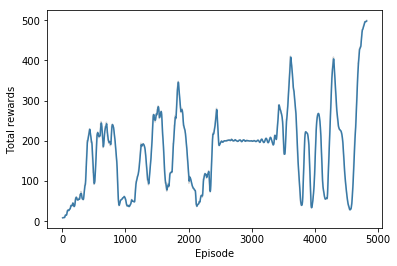

In [40]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

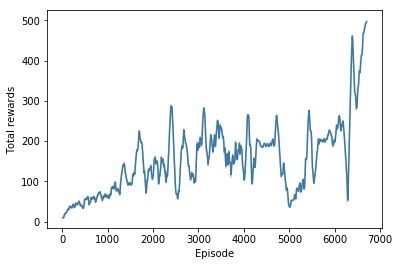

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

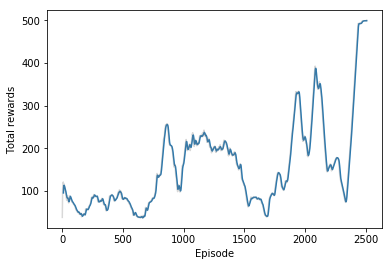

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

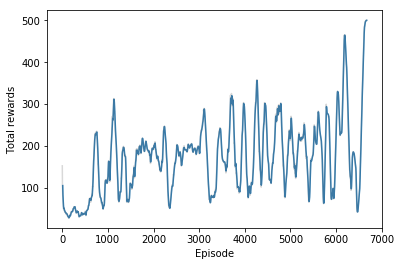

In [33]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

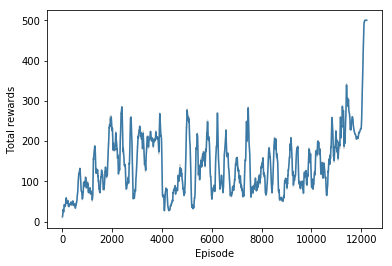

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

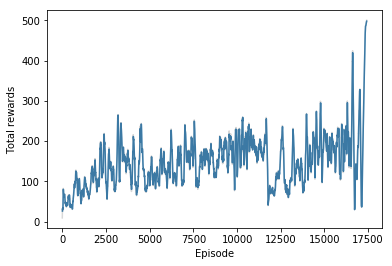

In [113]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

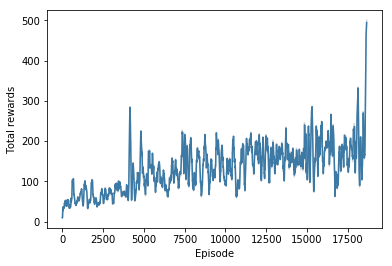

In [111]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

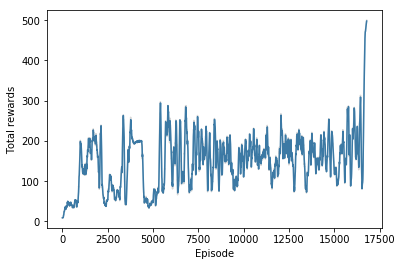

In [108]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

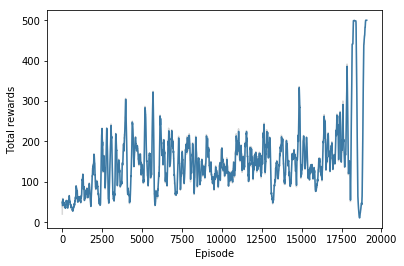

In [105]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

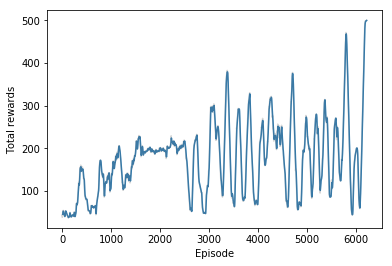

In [102]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

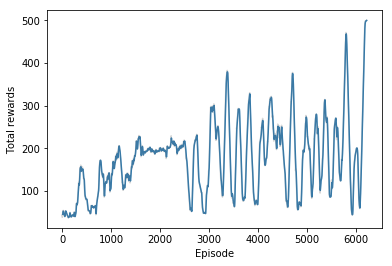

In [101]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

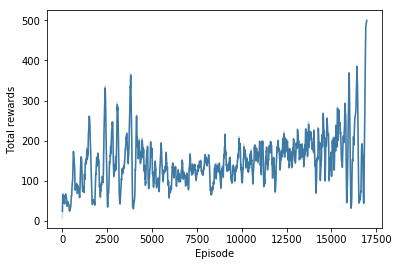

In [95]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

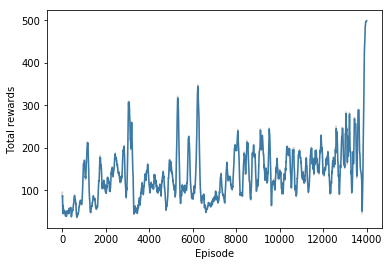

In [72]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

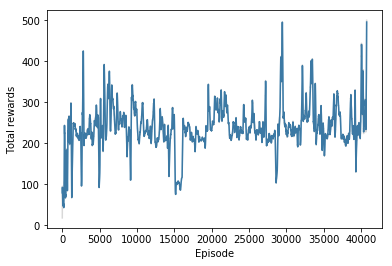

In [54]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

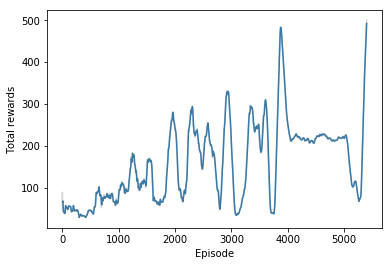

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

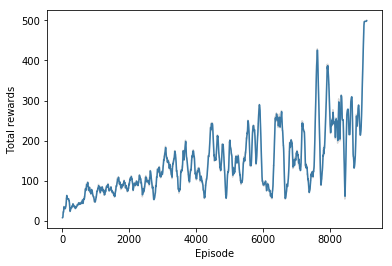

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

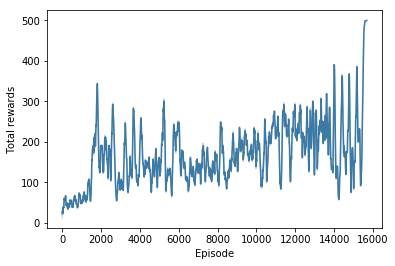

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

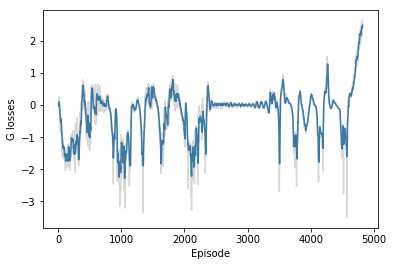

In [36]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

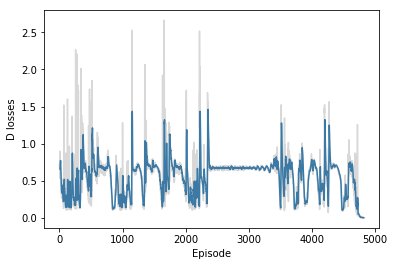

In [37]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

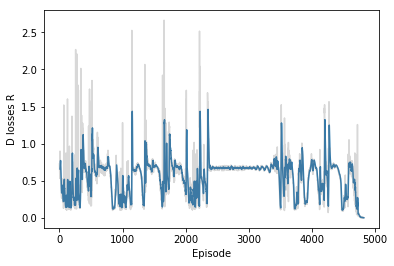

In [38]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

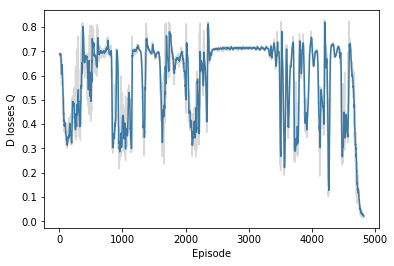

In [39]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.